In [455]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from glob import glob
from tqdm import tqdm
from IPython.display import display, HTML

from plotly.offline import iplot
#to link plotly to pandas
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline = False, world_readable = True)

import gc

import warnings
warnings.simplefilter('ignore')

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, average_precision_score
from sklearn.metrics import precision_recall_curve, auc

plt.rcParams["figure.figsize"] = (12, 10)
plt.rcParams['axes.titlesize'] = 12
sns.set_palette('Set3')

In [456]:
col = ["#9DC183", "#2A8EA6", "#F1C232", "#ECECEC", "#FF7F50"]
sns.set_palette(sns.color_palette(col))

In [457]:
SEED = 42
def seed_everything(seed = SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)

In [458]:
input_files = glob("./data/parsed_output/*.tsv")
print(f"Num of training files: {len(input_files)}")
input_files[:10]

Num of training files: 4133


['./data/parsed_output/Platyla_gracilis_parsed.tsv',
 './data/parsed_output/Albinaria_mixta_parsed.tsv',
 './data/parsed_output/Trochomorpha_melvillensis_parsed.tsv',
 './data/parsed_output/Viviparus_acerosus_parsed.tsv',
 './data/parsed_output/Macedonica_martae_parsed.tsv',
 './data/parsed_output/Promenetus_exacuous_parsed.tsv',
 './data/parsed_output/Conus_flavidus_parsed.tsv',
 './data/parsed_output/Sepia_mestus_parsed.tsv',
 './data/parsed_output/Ancylus_tapirulus_parsed.tsv',
 './data/parsed_output/Crassostrea_tulipa_parsed.tsv']

In [509]:
header = ["year", "class", "order", "family", "genus", "scientific_name", "latitude", "longitude", "elevation", "depth",
        "taxon_key", "n_native", "n_pres", "n_vagabond", "n_class", "n_order", "n_family", "n_genus", "iucn_status",
        "max_temp", "min_temp", "mean_temp", "prec_sum_mean"]
len(header)

23

In [460]:
# df_all = pd.read_csv("./data/01-All_Mollusca_parsed.tsv", names=header, sep="\t", index_col=False)
# # df_all.drop(exclude, axis=1, inplace=True)
# print(df_all.shape)
# df_all.head()

In [510]:
# Check a single txt file
temp = pd.read_csv(np.random.choice(input_files, 1)[0], sep="\t", names=header, index_col=False).melt(id_vars="year").sort_values(by="year")
temp.head()

,year,variable,value
0,1972,class,Bivalvia
147,1972,prec_sum_mean,4.933607
35,1972,latitude,28.2289
42,1972,longitude,112.959
49,1972,elevation,NaN


In [511]:
pid = temp[temp['variable'] == 'scientific_name']['value'].values[0]
target = temp[temp['variable'] == 'iucn_status']['value'].values[0]

print(f"{pid}: {target}")

def plot_parameters(df: pd.DataFrame, pid: float, target: int):
    color = ['red', 'green', 'orange', 'blue']
    for i, p in enumerate(['mean_temp', 'n_genus']):
        temp = df[['year', 'value']][df['variable'] == p]
        if not temp.empty:
            df[['year', 'value']][df['variable'] == p].iplot(kind = 'line', 
                                                               x = 'year', 
                                                               y = 'value', 
                                                               xTitle = 'Time',
                                                               yTitle = p,
                                                               title = f'<b>Parameter: {p}; RecordID: {pid}; Mortality: {target}</b>',
                                                               color = col[i])

Acuticosta chinensis: LC


In [512]:
plot_parameters(temp, pid, target)

CufflinksError: Not a valid color: o

### Check number of Timepoints

In [464]:
num_feat = ["depth", "n_native", "n_pres", "n_vagabond", "n_class", "n_order", "n_family", "n_genus", "max_temp",
              "elevation", "min_temp", "mean_temp", "prec_sum_mean"]
cat_feat = ["class", "order", "iucn_status"]

In [465]:
def extract_to_dict(df: pd.DataFrame, num_feat: list, cat_feat: list) -> pd.DataFrame:
    patient_dict = {"scientific_name": df['scientific_name'][0]}
    for feat in num_feat:
        df_melted = df.melt(id_vars="year").sort_values(by="year")
        patient_dict[feat] = round(df_melted[df_melted['variable'] == feat]['value'].mean(), 2)
    for feat in cat_feat:
        df_sorted = df.sort_values(by="year")
        patient_dict[feat] = df_sorted[feat].iloc[-1]
    return pd.DataFrame(patient_dict, index = [0])

In [466]:
def get_dict(df_all, species_dict):
    for sp in df_all['scientific_name']:
        if sp not in species_dict:
            species_dict[sp] = 1
        else:
            species_dict[sp] += 1

In [467]:
df = pd.DataFrame()
species_dict = {}

for file in tqdm(input_files):
    temp = pd.read_csv(file, sep="\t", names=header, index_col=False)
    get_dict(temp, species_dict=species_dict)
    df = df.append(extract_to_dict(temp, num_feat=num_feat, cat_feat=cat_feat))
print(df.shape)
len(set(df['scientific_name']))

100%|██████████| 4133/4133 [00:49<00:00, 84.10it/s]

(4133, 17)


4132

[(0.0, 50.0)]

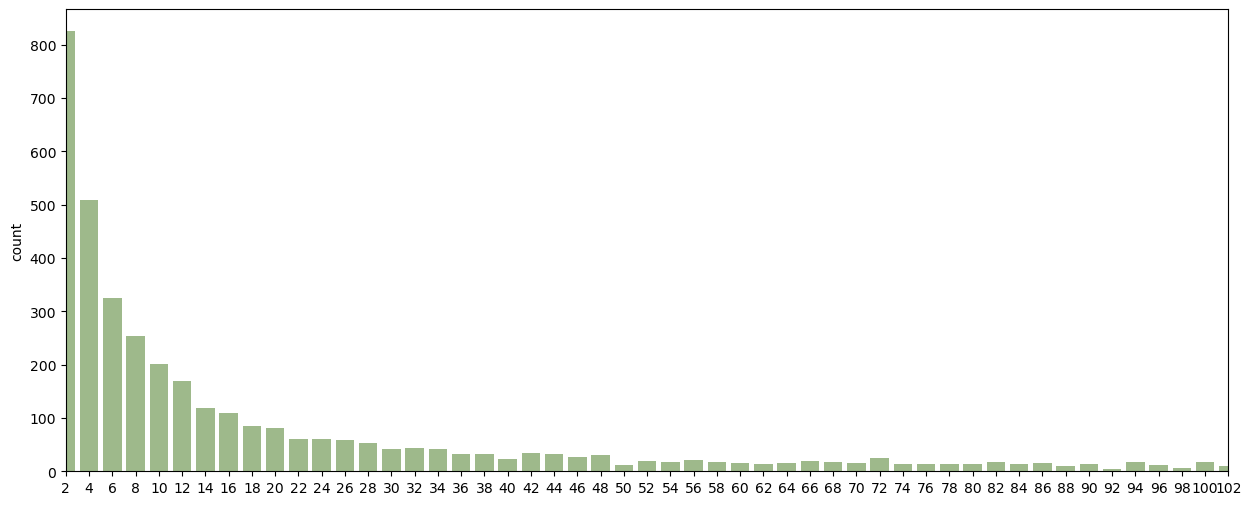

In [468]:
plt.figure(figsize=(15,6))

g = sns.countplot(x = list(species_dict.values()), color=col[0])
g.set(xlim=(0, 50))

## Preprocessing

In [469]:

# Missing values plot
missing = df.isna().sum().reset_index()
missing.columns = ['features', 'total_missing']
missing['percent'] = (missing['total_missing'] / len(df)) * 100
missing.index = missing['features']
del missing['features']

missing['percent'].iplot(kind = 'bar', 
                               title = f'<b>Missing Values Count in Dataset</b>',
                               xTitle = 'Features',
                               colors = 'blue',
                               yTitle = 'Percent')
missing.T

features,scientific_name,depth,n_native,n_pres,n_vagabond,n_class,n_order,n_family,n_genus,max_temp,elevation,min_temp,mean_temp,prec_sum_mean,class,order,iucn_status
total_missing,0.0,3033.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,870.000000,3210.000000,870.000000,870.000000,870.000000,0.0,462.000000,0.0
percent,0.0,73.38495,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.050085,77.667554,21.050085,21.050085,21.050085,0.0,11.178321,0.0


In [470]:
df['iucn_status'].value_counts()

LC       2325
VU        481
NT        318
CR        287
EN        278
EX        127
LR/nt      70
V          58
I          48
E          41
R          26
DD         22
EW         16
LR/lc      11
K          10
Ex          7
LR/cd       5
Ex?         3
Name: iucn_status, dtype: int64

Recode IUCN classes

In [471]:
# new_map = { "LC": "Least concern",
#     "NT": "Low risk",
#     "LR/nt": "Low risk",
#     "LR/cd": "Low risk",
#     "LR/lc": "Low risk",
#     "VU": "Endangered",
#     "EN":"Endangered",
#     "CR":"Endangered",
#     "EW": "Extinct",
#     "EX": "Extinct",
#     "Ex": "Extinct",
#     "Ex?": "Extinct",
#     "DD": "DD",
#     "V": "V",
#     "I": "I",
#     "E": "E",
#     "R": "R",
#     "K": "K"
# }

# df.replace({"iucn_status": new_map}, inplace=True)
# for i in ["DD", "V", "I", "E", "R", "K"]:
#     df = df[df.iucn_status != i]

# df.shape

In [472]:
# Binary classification

new_map = { "LC": "Least concern",
    "NT": "Endangered",
    "LR/nt": "Endangered",
    "LR/cd": "Endangered",
    "LR/lc": "Endangered",
    "VU": "Endangered",
    "EN":"Endangered",
    "CR":"Endangered",
    "EW": "Endangered",
    "EX": "Endangered",
    "Ex": "Endangered",
    "Ex?": "Endangered",
    "DD": "DD",
    "V": "V",
    "I": "I",
    "E": "E",
    "R": "R",
    "K": "K"
}


df.replace({"iucn_status": new_map}, inplace=True)
for i in ["DD", "V", "I", "E", "R", "K"]:
    df = df[df.iucn_status != i]

df.shape

(3928, 17)

In [473]:
df = df.set_index([pd.Index([x for x in range(df.shape[0])])])
df.head()

,scientific_name,depth,n_native,n_pres,n_vagabond,n_class,n_order,n_family,n_genus,max_temp,elevation,min_temp,mean_temp,prec_sum_mean,class,order,iucn_status
0,Platyla gracilis,NaN,7.0,0.0,0.0,1213.0,63.0,14.0,6.0,28.34,545.33,-18.40,7.07,3.83,Gastropoda,Architaenioglossa,Least concern
1,Albinaria mixta,NaN,1.0,0.0,0.0,1213.0,399.0,39.0,2.0,39.90,NaN,-0.10,17.46,0.98,Gastropoda,Stylommatophora,Least concern
2,Trochomorpha melvillensis,NaN,1.0,0.0,0.0,1213.0,399.0,1.0,7.0,34.50,NaN,19.00,26.96,4.06,Gastropoda,Stylommatophora,Endangered
3,Viviparus acerosus,NaN,12.0,0.0,0.0,1213.0,63.0,17.0,3.0,34.46,NaN,-10.47,12.38,1.80,Gastropoda,Architaenioglossa,Endangered
4,Macedonica martae,NaN,1.0,0.0,0.0,1213.0,399.0,39.0,1.0,NaN,NaN,NaN,NaN,NaN,Gastropoda,Stylommatophora,Endangered


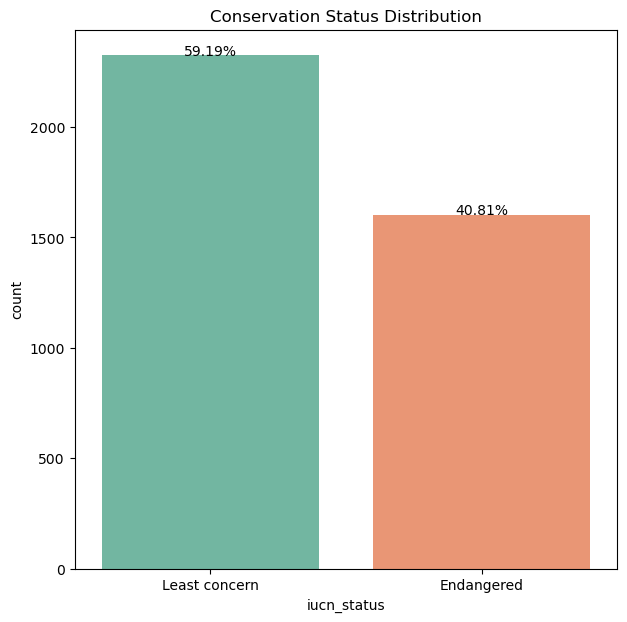

In [474]:
plt.figure(figsize = (7, 7))
ax = sns.countplot(df, x='iucn_status', order=df['iucn_status'].value_counts().index, palette = 'Set2')
plt.title('Conservation Status Distribution')
for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width() / 2.0, height + 0.5,
                f"{round(100 * height / len(df), 2)}%",
                ha = 'center')

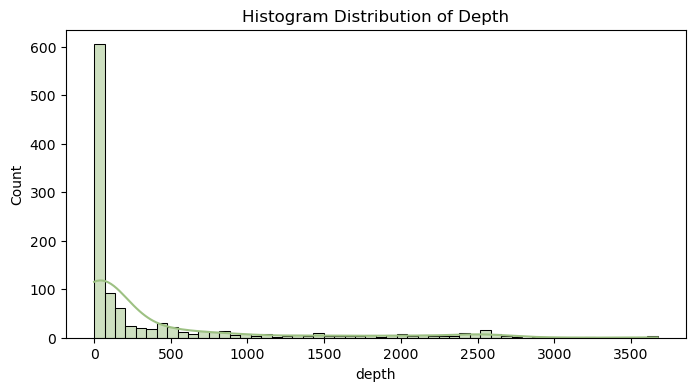

In [475]:
plt.figure(figsize = (8, 4))
plt.title("Histogram Distribution of Depth")
sns.histplot(df['depth'], color = col[0], kde = True);

In [476]:
cat_feat, num_feat

(['class', 'order', 'iucn_status'],
 ['depth',
  'n_native',
  'n_pres',
  'n_vagabond',
  'n_class',
  'n_order',
  'n_family',
  'n_genus',
  'max_temp',
  'elevation',
  'min_temp',
  'mean_temp',
  'prec_sum_mean'])

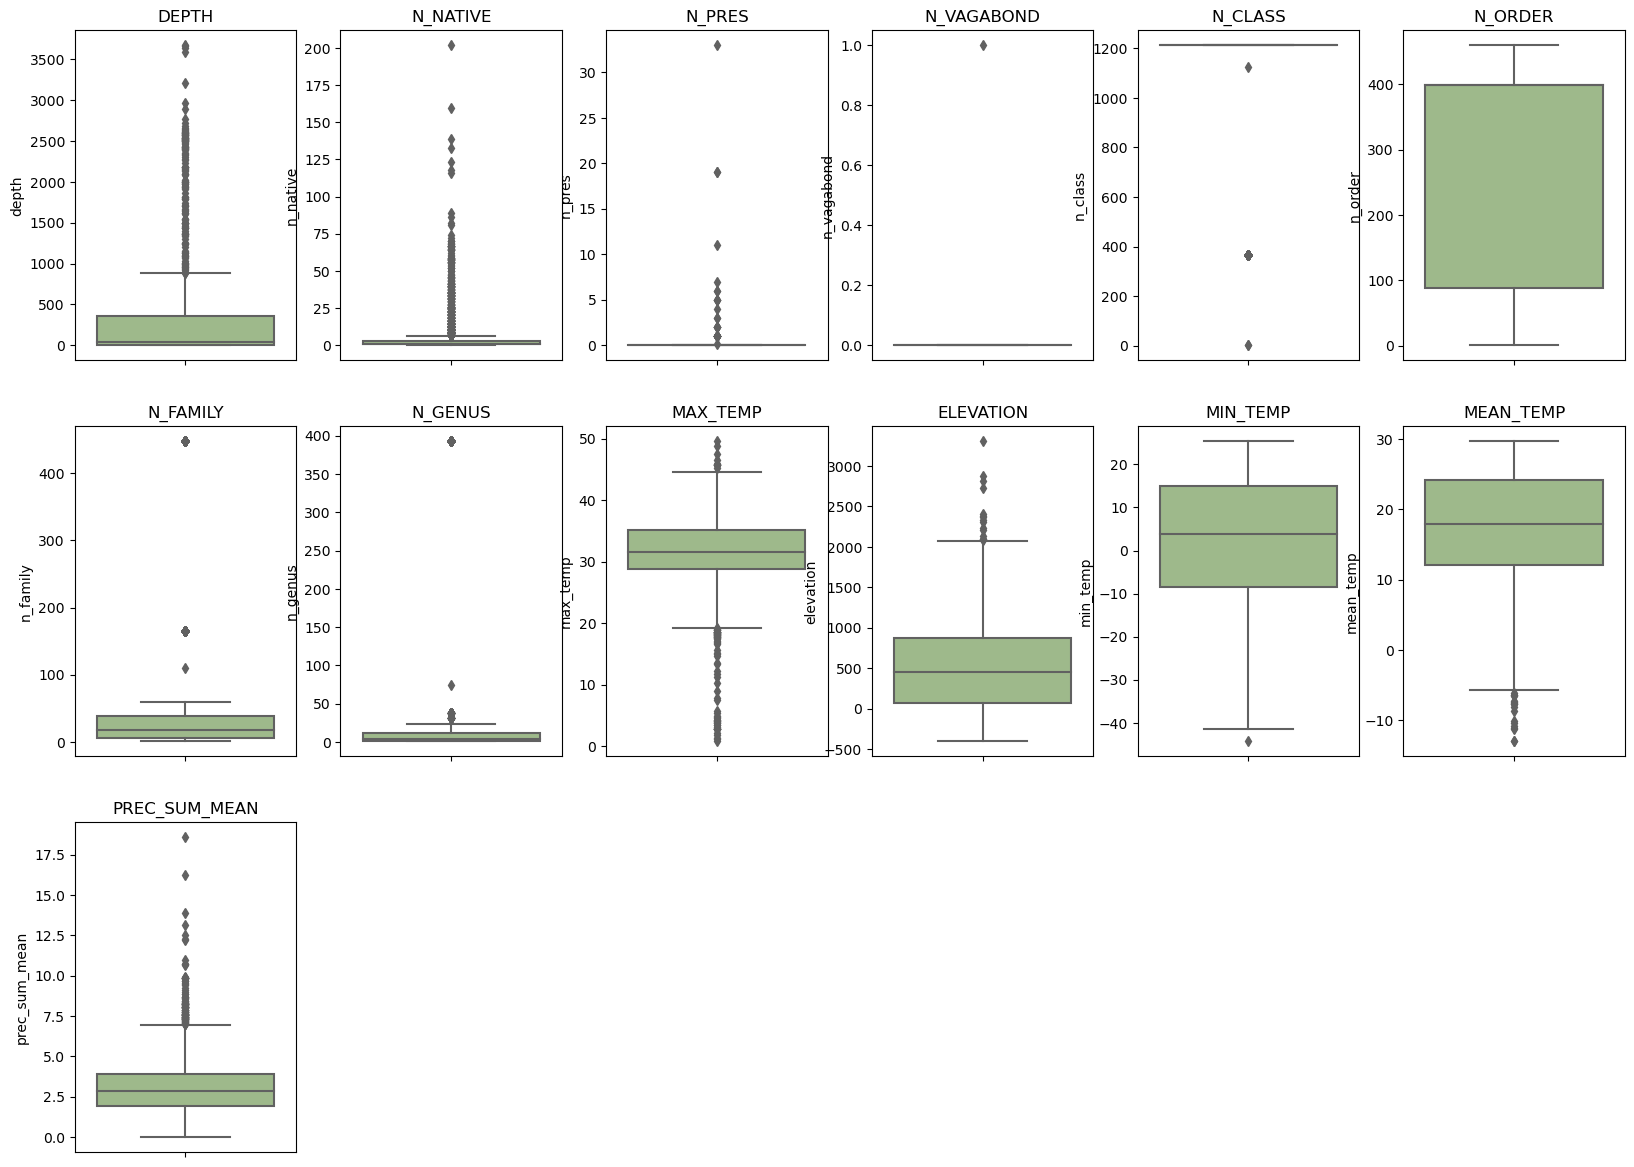

In [477]:
plt.figure(figsize = (20, 30))
for i, col in enumerate(df[num_feat]):
    plt.subplot(6, int(len(num_feat) / 2), i + 1)
    sns.boxplot(y = col, data = df)
    plt.title(col.upper())

In [478]:
# NaN imputation

#Impute Numerical Features with mean value
df[num_feat] = df[num_feat].fillna(df[num_feat].median())

#Impute Categorical Features with most frequent value
for col in cat_feat:
    df[col] = df[col].fillna(df[col].value_counts().index[0])

In [479]:
class2idx = {
    "Least concern":0,
    "Endangered":1,
}

idx2class = {v: k for k, v in class2idx.items()}

df['iucn_status'].replace(class2idx, inplace=True)

In [480]:
df

,scientific_name,depth,n_native,n_pres,n_vagabond,n_class,n_order,n_family,n_genus,max_temp,elevation,min_temp,mean_temp,prec_sum_mean,class,order,iucn_status
0,Platyla gracilis,39.955,7.0,0.0,0.0,1213.0,63.0,14.0,6.0,28.34,545.33,-18.400,7.070,3.83,Gastropoda,Architaenioglossa,0
1,Albinaria mixta,39.955,1.0,0.0,0.0,1213.0,399.0,39.0,2.0,39.90,450.00,-0.100,17.460,0.98,Gastropoda,Stylommatophora,0
2,Trochomorpha melvillensis,39.955,1.0,0.0,0.0,1213.0,399.0,1.0,7.0,34.50,450.00,19.000,26.960,4.06,Gastropoda,Stylommatophora,1
3,Viviparus acerosus,39.955,12.0,0.0,0.0,1213.0,63.0,17.0,3.0,34.46,450.00,-10.470,12.380,1.80,Gastropoda,Architaenioglossa,1
4,Macedonica martae,39.955,1.0,0.0,0.0,1213.0,399.0,39.0,1.0,31.58,450.00,3.725,17.845,2.85,Gastropoda,Stylommatophora,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3923,Alviniconcha marisindica,2426.330,1.0,0.0,0.0,1213.0,138.0,22.0,4.0,26.95,450.00,17.770,22.890,1.35,Gastropoda,Stylommatophora,1
3924,Conus cingulatus,52.670,2.0,0.0,0.0,1213.0,460.0,448.0,393.0,32.27,450.00,23.270,26.420,5.24,Gastropoda,Neogastropoda,0
3925,Pachnodus lionneti,39.955,1.0,0.0,0.0,1213.0,399.0,1.0,393.0,29.10,450.00,23.600,26.130,3.45,Gastropoda,Stylommatophora,1
3926,Reymondia tanganyicensis,39.955,2.0,0.0,0.0,1213.0,179.0,4.0,2.0,31.58,450.00,3.725,17.845,2.85,Gastropoda,Stylommatophora,1


In [481]:
print('Feature Correlation with target:')
df.corr()['iucn_status']

Feature Correlation with target:


depth            0.071442
n_native        -0.259167
n_pres          -0.044858
n_vagabond      -0.013250
n_class          0.200293
n_order         -0.039055
n_family        -0.170189
n_genus         -0.137384
max_temp         0.098950
elevation       -0.005833
min_temp         0.051547
mean_temp        0.080425
prec_sum_mean   -0.040419
iucn_status      1.000000
Name: iucn_status, dtype: float64

In [482]:
#Label Encoding age, gender, category
for col in ["class", "order"]:
    print(f"Label Encoding: {col} - {df[col].nunique()}")
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

Label Encoding: class - 5
Label Encoding: order - 31


In [483]:
std = StandardScaler()
df[num_feat] = std.fit_transform(df[num_feat])

In [484]:
X = df.drop(['scientific_name', 'iucn_status'], axis = 1)
y = df['iucn_status'].copy()

In [485]:
#scale_pos_weight - sample Weights
num_pos_samples = y.value_counts().values[1]
num_neg_samples = y.value_counts().values[0]

class_weight = num_neg_samples / num_pos_samples
print(f"scale_pos_weight:")
num_neg_samples / num_pos_samples, np.sqrt(num_neg_samples / num_pos_samples)

scale_pos_weight:


(1.4504054897067997, 1.2043278165461428)

## Models 

In [486]:
# Plots

def plot_pr_curve(precision, recall, avg_precision):
    plt.figure(figsize = (8, 6))
    plt.plot(recall, precision, label = f"Avg. PR: {round(avg_precision, 2)}")
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.5, 1.05])
    plt.xlim([0.55, 1.0])
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.show()

def plot_confusion(mat):
    plt.figure(figsize = (8, 4))
    sns.heatmap(pd.DataFrame(mat), annot = True, annot_kws = {"size": 25}, cmap = 'Blues', fmt = 'g')
    plt.title('Confusion matrix', y = 1.1, fontsize = 22)
    plt.ylabel('Actual', fontsize = 18)
    plt.xlabel('Predicted', fontsize = 18)
    plt.show()

def compute_precision_recall(conf_mat):
    #compute precision and recall
    tp_and_fn = conf_mat.sum(axis = 1)
    tp_and_fp = conf_mat.sum(axis = 0)
    tp = conf_mat.diagonal()
    precision = tp / tp_and_fp
    recall = tp / tp_and_fn
    return precision, recall

In [487]:
# XGB
import xgboost as xgb
from xgboost import XGBClassifier, plot_importance

xgb_params = {
         'objective': 'binary:logistic',
         'lambda': 0.0030282073258141168, 
         'alpha': 0.01563845128469084,
         'colsample_bytree': 0.55,
         'subsample': 0.7,
         'learning_rate': 0.01,
         'max_depth': 9,
         'random_state': 2020, 
         'min_child_weight': 257,
         'eval_metric': 'aucpr',
         'seed': 2021,
         'scale_pos_weight': num_neg_samples / num_pos_samples #np.sqrt(num_neg_samples / num_pos_samples)
}

In [488]:
n_folds = 10
preds_xg = []
overall_pr = []
all_precision, all_recall = [], []

skf = StratifiedKFold(n_splits = n_folds)

In [489]:
model_type = 'xgbclassifier'

###########################################################################################
Fold: 1
(3535, 15) (3535,) (393, 15) (393,)
Classifier: xgbclassifier
###########################################################################################


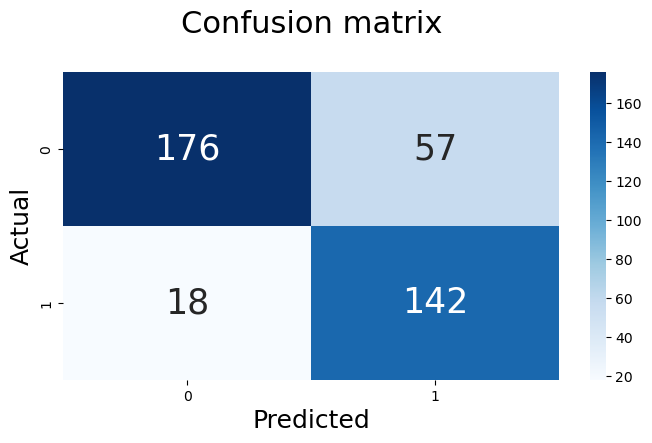


Avg. Precision-Recall Score: 0.8433219845420902


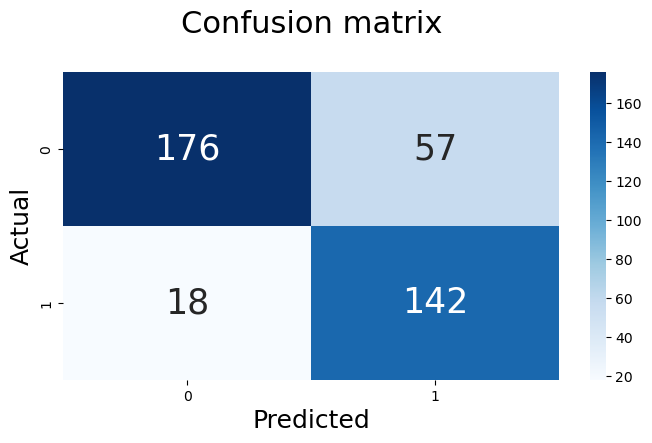

Classification Report: 
              precision    recall  f1-score   support

           0       0.91      0.76      0.82       233
           1       0.71      0.89      0.79       160

    accuracy                           0.81       393
   macro avg       0.81      0.82      0.81       393
weighted avg       0.83      0.81      0.81       393

###########################################################################################
Fold: 2
(3535, 15) (3535,) (393, 15) (393,)
Classifier: xgbclassifier
###########################################################################################


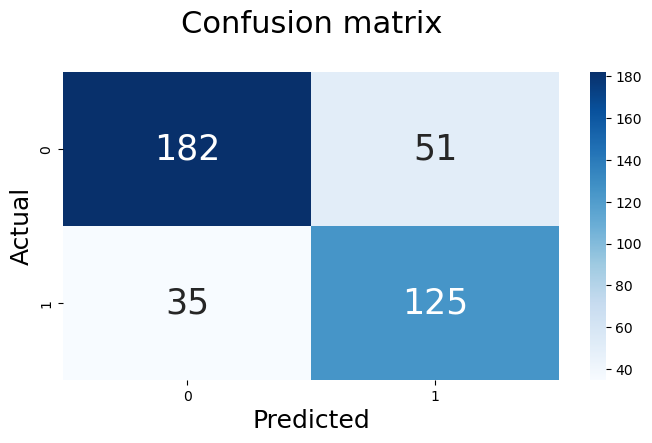


Avg. Precision-Recall Score: 0.826269544033288


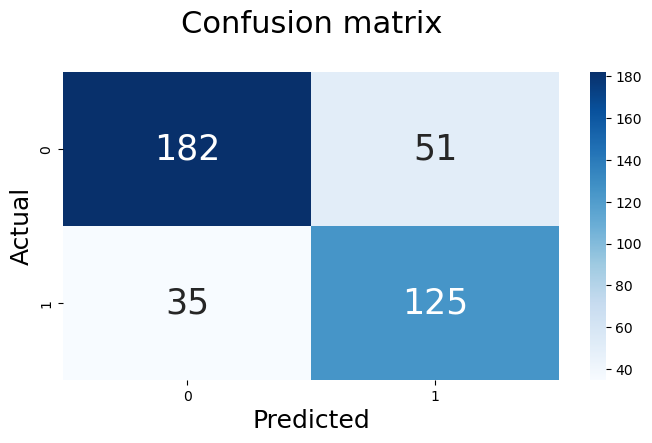

Classification Report: 
              precision    recall  f1-score   support

           0       0.84      0.78      0.81       233
           1       0.71      0.78      0.74       160

    accuracy                           0.78       393
   macro avg       0.77      0.78      0.78       393
weighted avg       0.79      0.78      0.78       393

###########################################################################################
Fold: 3
(3535, 15) (3535,) (393, 15) (393,)
Classifier: xgbclassifier
###########################################################################################


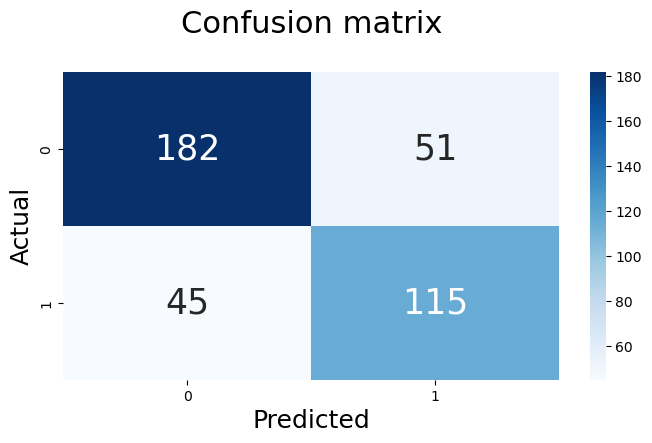


Avg. Precision-Recall Score: 0.7904732165152917


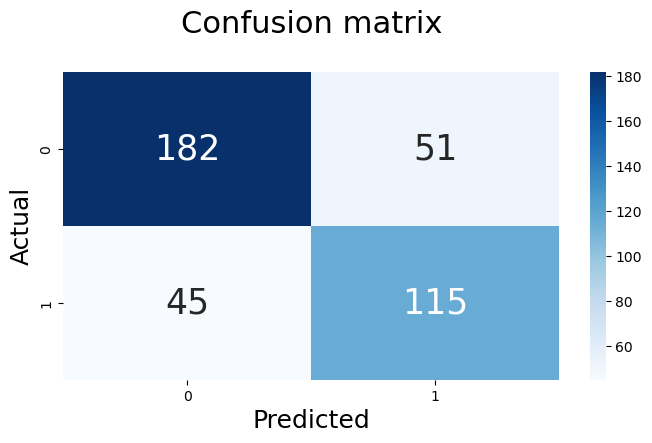

Classification Report: 
              precision    recall  f1-score   support

           0       0.80      0.78      0.79       233
           1       0.69      0.72      0.71       160

    accuracy                           0.76       393
   macro avg       0.75      0.75      0.75       393
weighted avg       0.76      0.76      0.76       393

###########################################################################################
Fold: 4
(3535, 15) (3535,) (393, 15) (393,)
Classifier: xgbclassifier
###########################################################################################


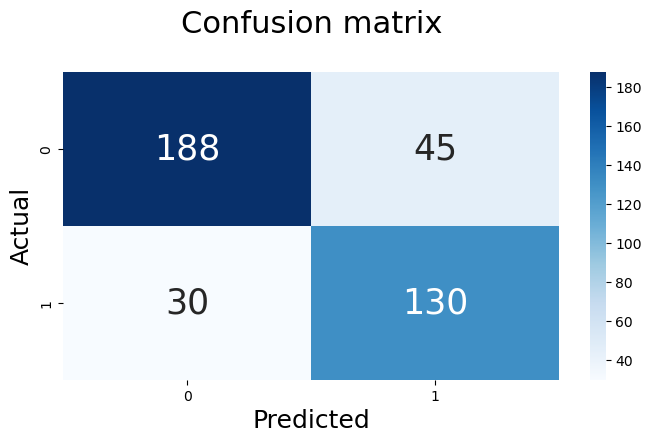


Avg. Precision-Recall Score: 0.8391420324987566


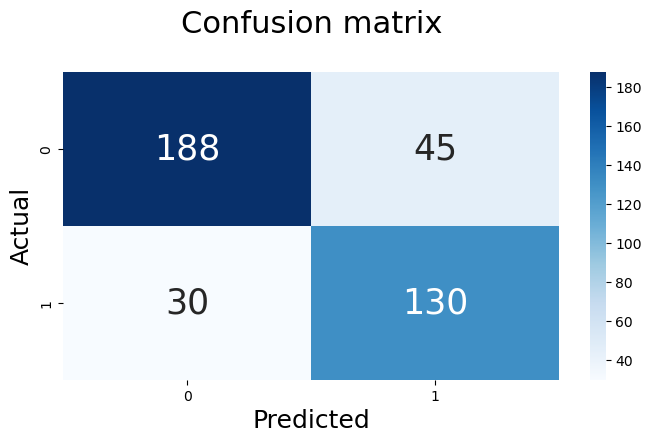

Classification Report: 
              precision    recall  f1-score   support

           0       0.86      0.81      0.83       233
           1       0.74      0.81      0.78       160

    accuracy                           0.81       393
   macro avg       0.80      0.81      0.80       393
weighted avg       0.81      0.81      0.81       393

###########################################################################################
Fold: 5
(3535, 15) (3535,) (393, 15) (393,)
Classifier: xgbclassifier
###########################################################################################


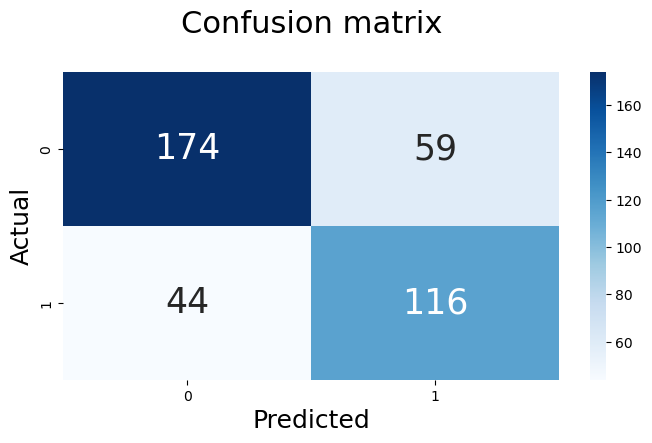


Avg. Precision-Recall Score: 0.7654603148751342


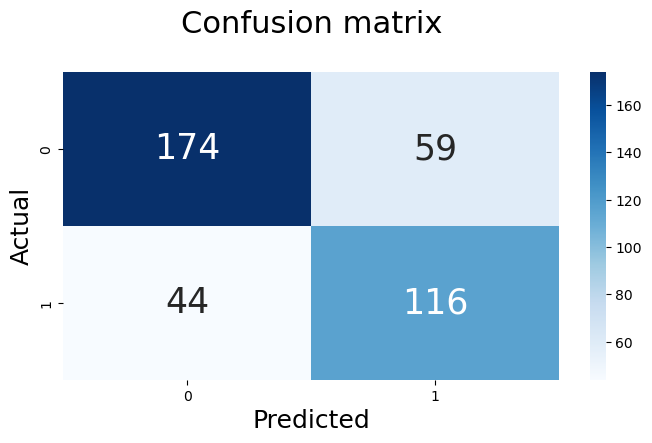

Classification Report: 
              precision    recall  f1-score   support

           0       0.80      0.75      0.77       233
           1       0.66      0.72      0.69       160

    accuracy                           0.74       393
   macro avg       0.73      0.74      0.73       393
weighted avg       0.74      0.74      0.74       393

###########################################################################################
Fold: 6
(3535, 15) (3535,) (393, 15) (393,)
Classifier: xgbclassifier
###########################################################################################


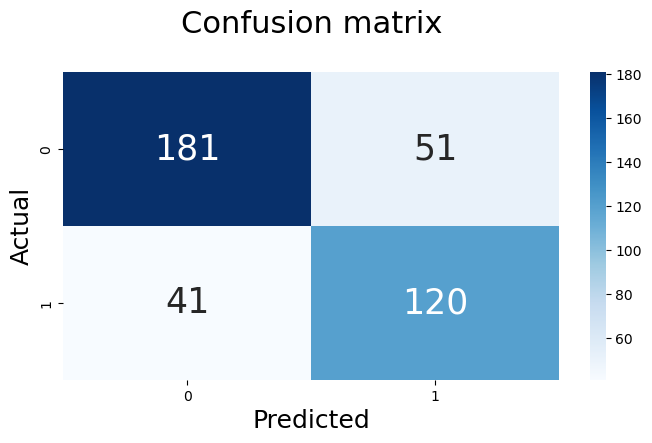


Avg. Precision-Recall Score: 0.798013377828318


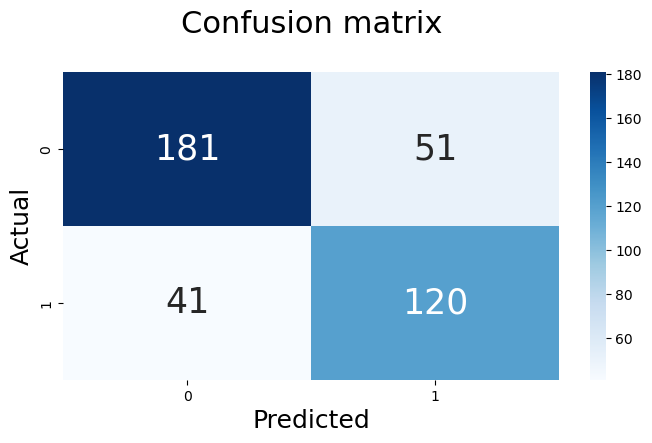

Classification Report: 
              precision    recall  f1-score   support

           0       0.82      0.78      0.80       232
           1       0.70      0.75      0.72       161

    accuracy                           0.77       393
   macro avg       0.76      0.76      0.76       393
weighted avg       0.77      0.77      0.77       393

###########################################################################################
Fold: 7
(3535, 15) (3535,) (393, 15) (393,)
Classifier: xgbclassifier
###########################################################################################


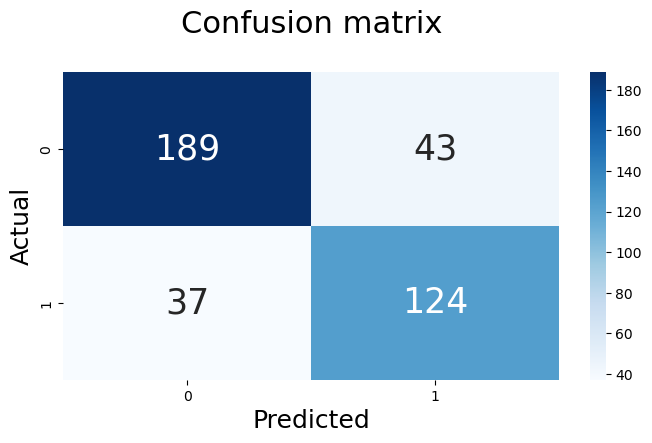


Avg. Precision-Recall Score: 0.8251418506727158


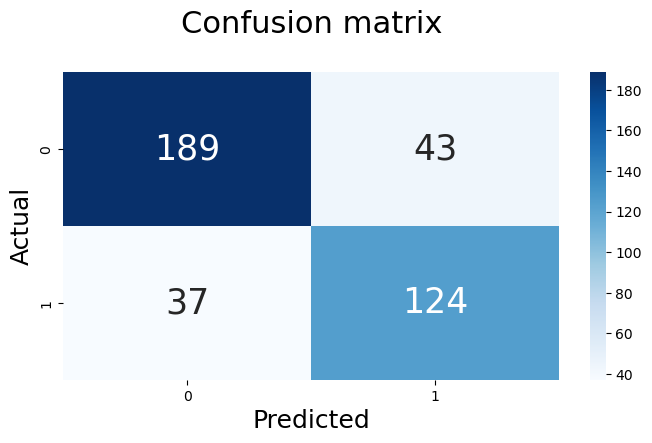

Classification Report: 
              precision    recall  f1-score   support

           0       0.84      0.81      0.83       232
           1       0.74      0.77      0.76       161

    accuracy                           0.80       393
   macro avg       0.79      0.79      0.79       393
weighted avg       0.80      0.80      0.80       393

###########################################################################################
Fold: 8
(3535, 15) (3535,) (393, 15) (393,)
Classifier: xgbclassifier
###########################################################################################


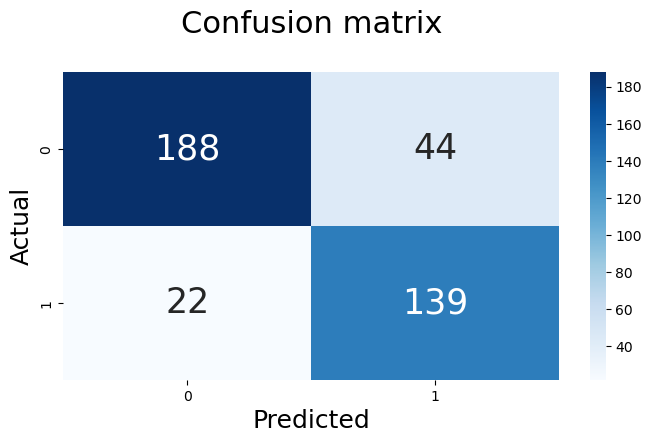


Avg. Precision-Recall Score: 0.8585140627695906


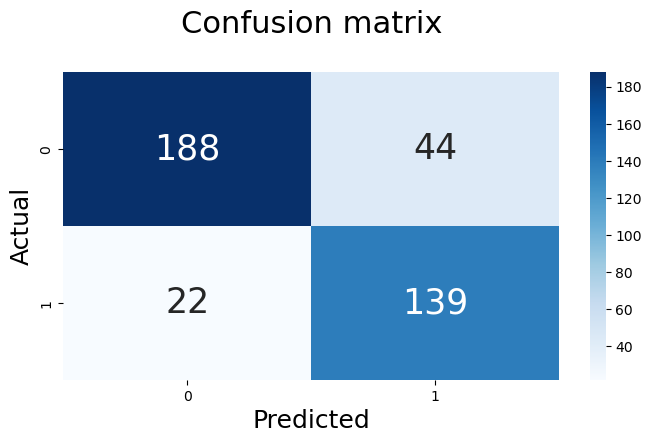

Classification Report: 
              precision    recall  f1-score   support

           0       0.90      0.81      0.85       232
           1       0.76      0.86      0.81       161

    accuracy                           0.83       393
   macro avg       0.83      0.84      0.83       393
weighted avg       0.84      0.83      0.83       393

###########################################################################################
Fold: 9
(3536, 15) (3536,) (392, 15) (392,)
Classifier: xgbclassifier
###########################################################################################


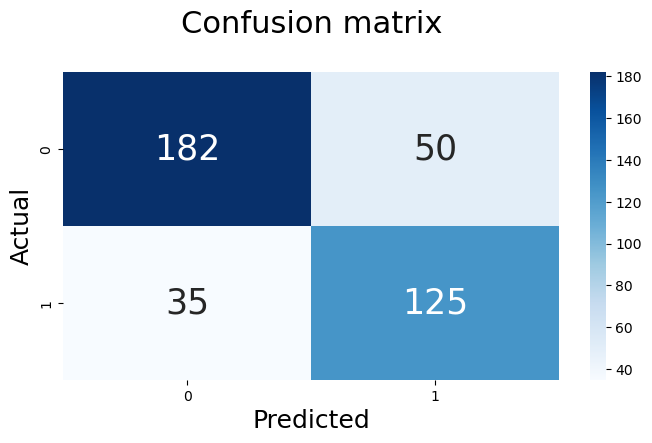


Avg. Precision-Recall Score: 0.8398825719730157


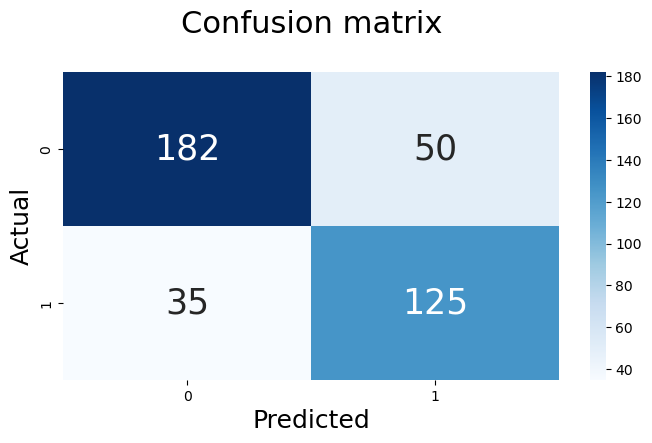

Classification Report: 
              precision    recall  f1-score   support

           0       0.84      0.78      0.81       232
           1       0.71      0.78      0.75       160

    accuracy                           0.78       392
   macro avg       0.78      0.78      0.78       392
weighted avg       0.79      0.78      0.78       392

###########################################################################################
Fold: 10
(3536, 15) (3536,) (392, 15) (392,)
Classifier: xgbclassifier
###########################################################################################


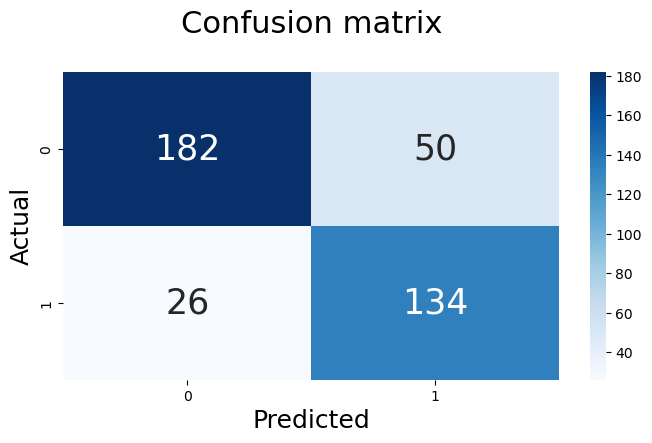


Avg. Precision-Recall Score: 0.8500814038550302


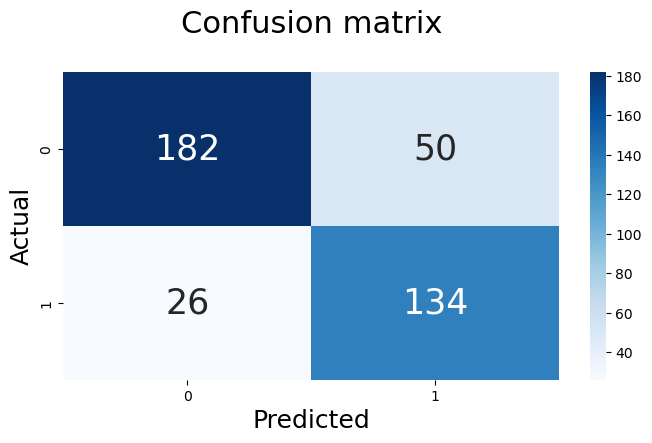

Classification Report: 
              precision    recall  f1-score   support

           0       0.88      0.78      0.83       232
           1       0.73      0.84      0.78       160

    accuracy                           0.81       392
   macro avg       0.80      0.81      0.80       392
weighted avg       0.82      0.81      0.81       392



In [494]:
from sklearn.metrics import average_precision_score, precision_recall_curve, precision_score

for i, (trn_idx, val_idx) in enumerate(skf.split(X, y)):
    print('#############' * 7)
    print(f"Fold: {i + 1}")
    Xtrain, ytrain = X.iloc[trn_idx], y[trn_idx]
    Xvalid, yvalid = X.iloc[val_idx], y[val_idx]
    print(Xtrain.shape, ytrain.shape, Xvalid.shape, yvalid.shape)
    print(f"Classifier: {model_type}")
    print('#############' * 7)

    if model_type == 'xgboost':
        xg_train = xgb.DMatrix(Xtrain, label = ytrain)
        xg_valid = xgb.DMatrix(Xvalid, label = yvalid)

        clf = xgb.train(xgb_params,
                          xg_train,
                          5000,
                          verbose_eval = 50,
                          evals = [(xg_train, 'train'), (xg_valid, 'valid')],
                          early_stopping_rounds = 100
                       )

        valid_preds = clf.predict(xg_valid)

    if model_type == 'xgbclassifier':
        clf = XGBClassifier(scale_pos_weight = class_weight, eval_metric = 'aucpr',
                                random_state = 42, n_jobs = -1)
        clf.fit(Xtrain, ytrain)
        valid_preds = clf.predict_proba(Xvalid)[:,1]

    conf_mat = confusion_matrix(yvalid, valid_preds > 0.5)

    #compute precision and recall
    pre, rec = compute_precision_recall(conf_mat)
    all_precision.append(pre)
    all_recall.append(rec)
    plot_confusion(conf_mat)
        
    avg_precision = average_precision_score(yvalid, valid_preds)
    print(f'\nAvg. Precision-Recall Score: {avg_precision}')
    overall_pr.append(avg_precision)

    pre, rec = compute_precision_recall(conf_mat)
    all_precision.append(pre)
    all_recall.append(rec)
    plot_confusion(conf_mat)

    print(f"Classification Report: \n{classification_report(yvalid, valid_preds > 0.5, labels = [0, 1])}")

In [495]:
print(f"Overall Avg CV Score: {np.mean(overall_pr)}")
print(f"Avg. Precision: {np.mean(all_precision)}\nAvg. Recall: {np.mean(all_recall)}")

Overall Avg CV Score: 0.8236300359563231
Avg. Precision: 0.7818722141355948
Avg. Recall: 0.7884007276902627


## SHAP

In [496]:
import shap

#Shap values with XGBoost core model
#Getting the shap values using the model is faster than usual way
booster_xgb = clf.get_booster()
shap_values_xgb = booster_xgb.predict(xgb.DMatrix(Xtrain, ytrain), pred_contribs = True)


In [497]:
shap_values_xgb = shap_values_xgb[:, :-1]
print(shap_values_xgb.shape)
pd.DataFrame(shap_values_xgb, columns = Xtrain.columns.tolist()).head()

(3536, 15)


,depth,n_native,n_pres,n_vagabond,n_class,n_order,n_family,n_genus,max_temp,elevation,min_temp,mean_temp,prec_sum_mean,class,order
0,-0.017686,-5.304588,0.009377,0.0,0.040151,0.132315,-0.093878,-0.094956,-0.181628,-0.013669,-0.149817,-0.298238,-0.326963,-0.045352,-0.233570
1,0.085142,0.818098,0.009665,0.0,0.039906,-0.091094,-1.098469,0.047167,0.271235,0.010950,-0.585492,-0.036617,-0.163312,-0.017829,-0.151310
2,0.046745,1.037570,0.009304,0.0,0.042596,0.126671,0.854519,-0.060894,-0.002889,0.003565,0.748658,0.401496,0.057484,0.020748,0.141936
3,0.075366,-2.048687,0.009233,0.0,0.033561,0.170581,-0.549600,0.503849,0.619406,0.077098,1.394132,0.491833,1.258668,-0.150672,0.279075
4,0.063752,0.837792,0.009860,0.0,0.070465,-0.099899,-0.500008,0.018464,0.223453,-0.049772,-0.176122,0.043123,0.073651,-0.012508,-0.115737


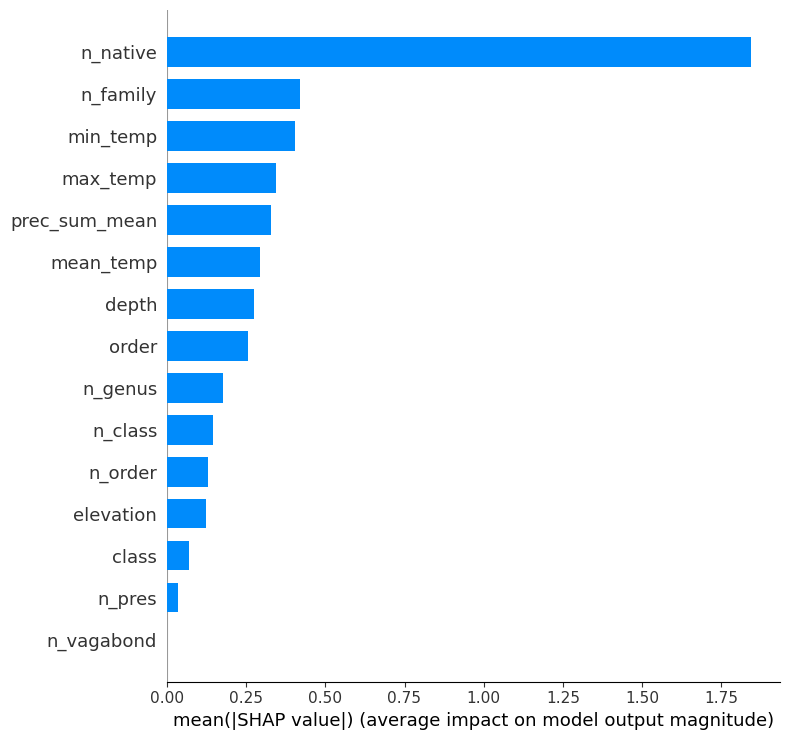

In [498]:
shap.summary_plot(shap_values_xgb, Xtrain, feature_names = Xtrain.columns, plot_type = "bar")

In [500]:
#importances are just the average absolute Shapley values for a feature. We can check that below:
pd.DataFrame(shap_values_xgb, columns = Xtrain.columns)["mean_temp"].abs().mean()

0.29231766

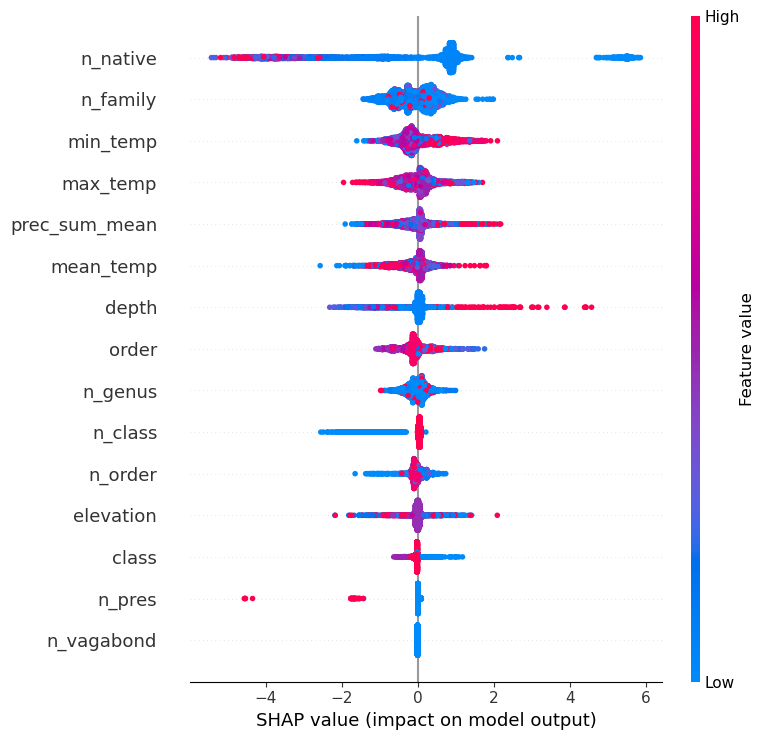

In [501]:
shap.summary_plot(shap_values_xgb, Xtrain, feature_names = Xtrain.columns);

### Save and load model

In [535]:
# Save model
clf.save_model("./model/preextinction.json")

# Save normalized matrix
pd.DataFrame(X).to_csv("./model/mat.csv", index=False)

# Save i2species
pd.DataFrame(df['scientific_name']).to_csv("./model/i2species.csv", index=False)

In [559]:
preextinction = xgb.XGBClassifier()
preextinction.load_model("./model/preextinction.json")

In [565]:
data_df = pd.read_csv("./model/mat.csv", index_col=False)
i2species_df = pd.read_csv("./model/i2species.csv", index_col=False)

def make_prediction(model, i2species, df, species):
    idx = i2species.index[i2species["scientific_name"]==species]
    pred_arr = df.iloc[idx]
    return(model.predict(pred_arr))

pred = make_prediction(preextinction, i2species_df, data_df, "Conus cingulatus")
print(0)

0
